In [1]:
%matplotlib widget 
import py4DSTEM
import numpy
import pyxem as pxm
import numpy as np
import matplotlib.pyplot as plt
file_path_cif = r"C:\Users\tas72\Documents\PhD\dg606\pbi2_2h.cif"

In [2]:
def pythag_distance(item):
        pythag_d= np.sqrt((item[0]**2)+(item[1]**2))
        return pythag_d

C:\Users\tas72\.conda\envs\py4D_pyxem\lib\site-packages\pymatgen\io\cif.py:1169: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


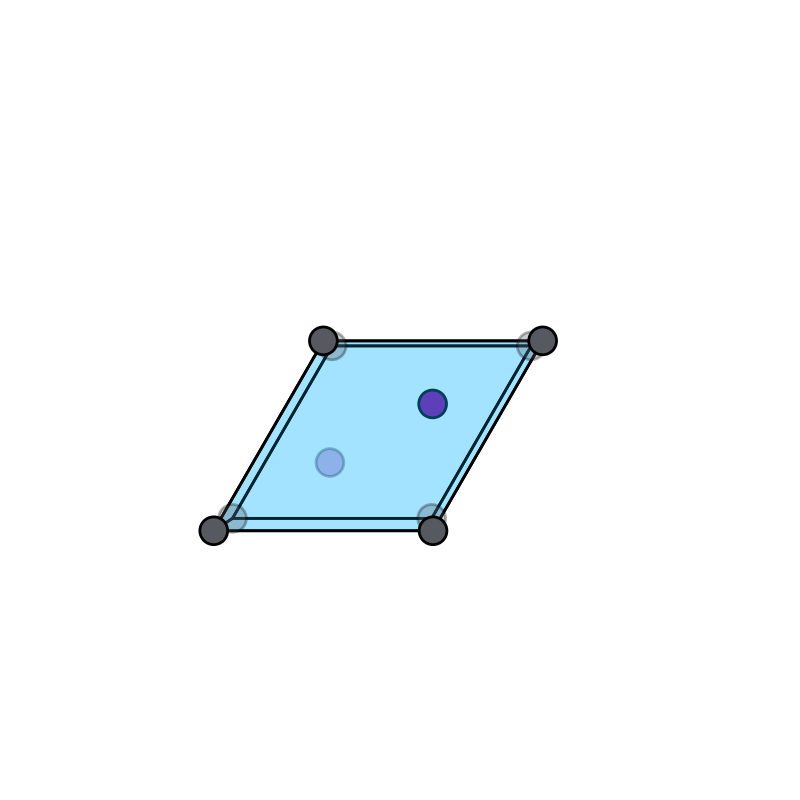

In [3]:
# Load the crystal structure
crystal = py4DSTEM.process.diffraction.Crystal.from_CIF(file_path_cif)
crystal.plot_structure()

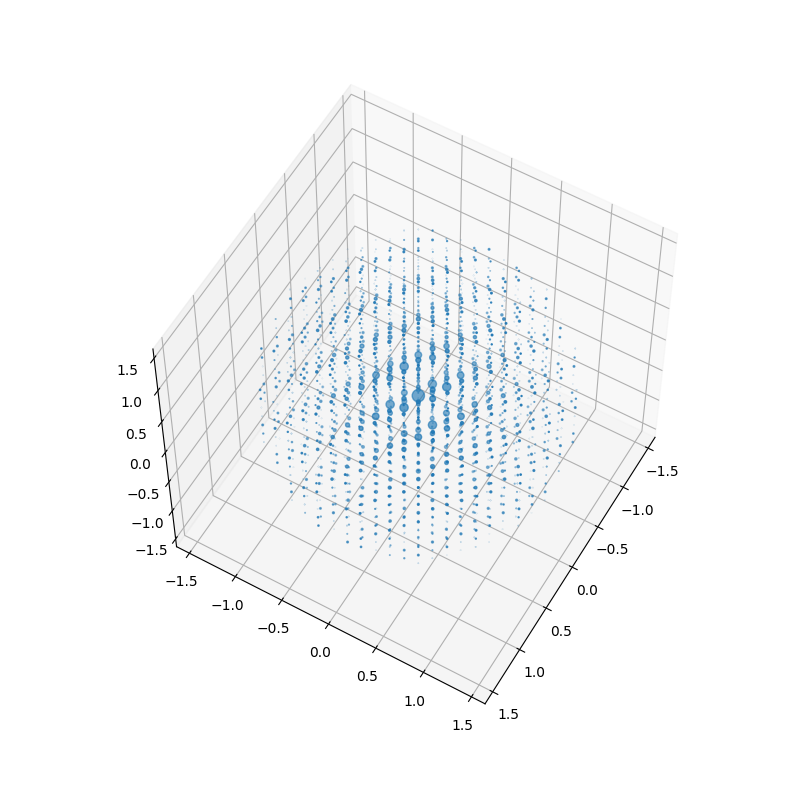

In [4]:
# Calculate and plot structure factors
k_max = 1.5

crystal.calculate_structure_factors(
    k_max,
)

crystal.plot_structure_factors(
    zone_axis_lattice=[1,1,1])

In [5]:
crystal.orientation_plan(
    zone_axis_range = 'full',
    angle_step_zone_axis = 1,
    angle_coarse_zone_axis = 1.0,
    angle_refine_range = 1.0,
    #
    angle_step_in_plane = 0.5,
    accel_voltage = 200e3,
    CUDA=False,
#     intensity_power = 0.5,
#     intensity_power = 0.125,
#     radial_power = 0.0,
#     corr_kernel_size = 0.16,
#     tol_peak_delete = 0.02,
)

Orientation plan: 100%|█████████████████████████████████████████████████| 16381/16381 [01:21<00:00, 199.81 zone axes/s]


In [6]:
len(crystal.orientation_rotation_matrices)

16381

In [10]:
sigma_compare = 0.01
test = crystal.generate_diffraction_pattern(
    orientation_matrix = crystal.orientation_rotation_matrices[0],
    sigma_excitation_error=sigma_compare,
    return_orientation_matrix= True)

In [11]:
test[1]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

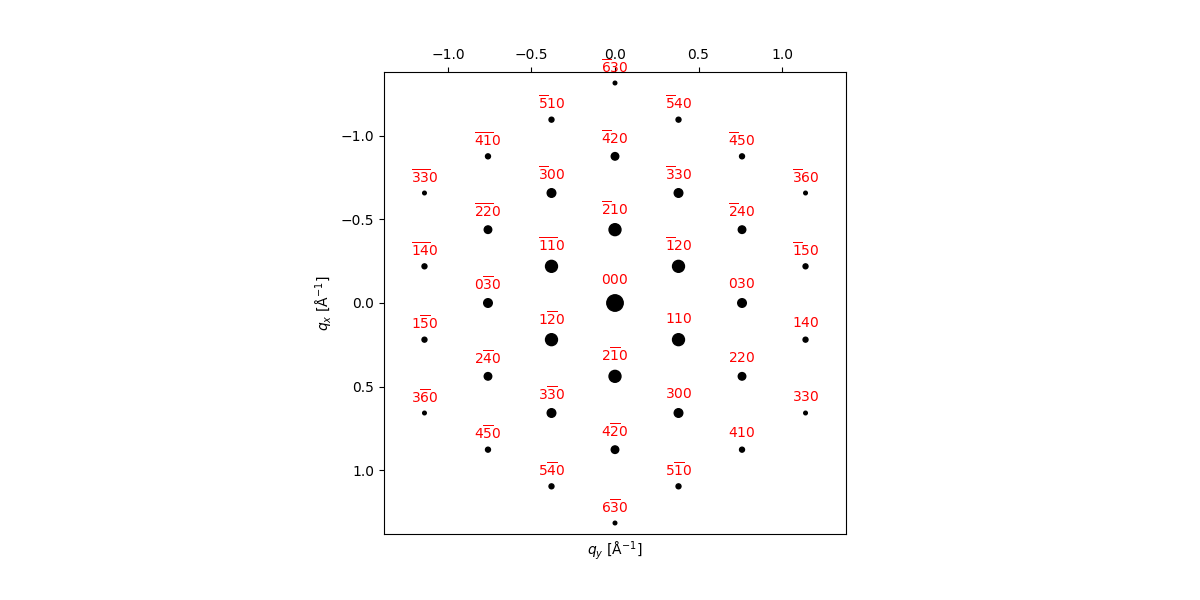

In [12]:
py4DSTEM.process.diffraction.plot_diffraction_pattern(
   test[0])

Now get the adjacency matricies

In [369]:
lengths = np.zeros(np.shape(test[0].data)[0])
for i in range(np.shape(test[0].data)[0]):
    data = test[0].data[i]
    
    x,y = data[0],data[1]
    lengths[i] = pythag_distance((x,y))
np.argsort(lengths)
sorted_data = np.zeros_like(test[0].data)
sorted_lengths = np.zeros_like(lengths)
i=0
for ind in np.argsort(lengths):
    sorted_data[i] = test[0].data[ind]
    sorted_lengths[i] = lengths[ind]  
    i+=1
  

In [385]:
groups = []
for i in range(len(sorted_lengths)):
    try:
        point = sorted_lengths[i]
        arg = np.argwhere(sorted_lengths>point+0.01)
        groups.append([np.amin(arg)])
    except:
        pass
    
groups = np.unique(groups)
groups = np.insert(groups,0,0)

In [386]:
groups

array([ 0,  1,  3,  5,  7,  9, 11, 13, 15, 16, 17, 21, 22, 24, 25, 27],
      dtype=int64)

In [371]:
adj_matrix_points_list = []

for i in range(len(groups)):
    if i == 0: # -0 is still 0
        continue
        
    group_start = groups[-i]    
    group_end = groups[(-i+1)] # the end group is where the group goes until    
    start_of_group_below = groups[-i-1]
    
    
    if group_end == 0: # put a catch for the end group
        group_end = len(sorted_lengths)
        
        
    lengths_oi = sorted_lengths[group_start:group_end]
    points_oi = sorted_data[group_start:group_end]
    
    
    
    
    points_oi_group_below = sorted_data[start_of_group_below:group_start]
    
    
    
    
    if i == 1: # If on first round define a random start
        poi = points_oi[0]
        loi = lengths_oi[0]
        
        
    
    complete_pythag_d = []
    
    for j in range(len(points_oi_group_below)):
        x_below = points_oi_group_below[j][0]
        y_below = points_oi_group_below[j][1]
        pd = pythag_distance((poi[0]-x_below, poi[1]-y_below))
        complete_pythag_d.append(pd)
    
    where_possible_points_for_next_round = np.where(np.round(complete_pythag_d,4) == np.round(np.amin(complete_pythag_d),4))
    
    
    
    
    if i == 1: # Dont have a previous point in the last round
        adj_matrix_points_list.append(poi)
        adj_matrix_points_list.append(points_oi_group_below[where_possible_points_for_next_round[0][0]])
        previous_poi = poi
        poi =  points_oi_group_below[where_possible_points_for_next_round[0][0]]
        
    else: # If at the first point shouldn't matter which 
           
        ## Want the point which is closest to the previous point
        distance_from_prior_point = []

        for j in range(len(where_possible_points_for_next_round[0])):
            x_below = points_oi_group_below[where_possible_points_for_next_round[0][j]][0]
            y_below = points_oi_group_below[where_possible_points_for_next_round[0][j]][1]
            pd = pythag_distance((previous_poi[0]-x_below, previous_poi[1]-y_below))
            distance_from_prior_point.append(pd)
            
        ## Make the previous_poi the current one from this round
        adj_matrix_points_list.append(points_oi_group_below[where_possible_points_for_next_round[0][0]])

        previous_poi = poi
        ## Make the new poi the one that has the minimum distance from the previous one
        poi = points_oi_group_below[where_possible_points_for_next_round[0][np.argmin(distance_from_prior_point)]]
    

In [372]:
adj_matrix = np.zeros((len(adj_matrix_points_list),len(adj_matrix_points_list)))

In [373]:
for i in range(np.shape(adj_matrix_points_list)[0]):
    current_poi = np.flip(adj_matrix_points_list)[i]
    other_points = [x for x in range(np.shape(adj_matrix_points_list)[0])]
    other_points.remove(i)
    
    for j in range(len(other_points)):
        other_point = np.flip(adj_matrix_points_list)[other_points[j]]
        pd = pythag_distance((current_poi[0]-other_point[0], current_poi[1]-other_point[1]))
        adj_matrix[i,other_points[j]] = pd
        


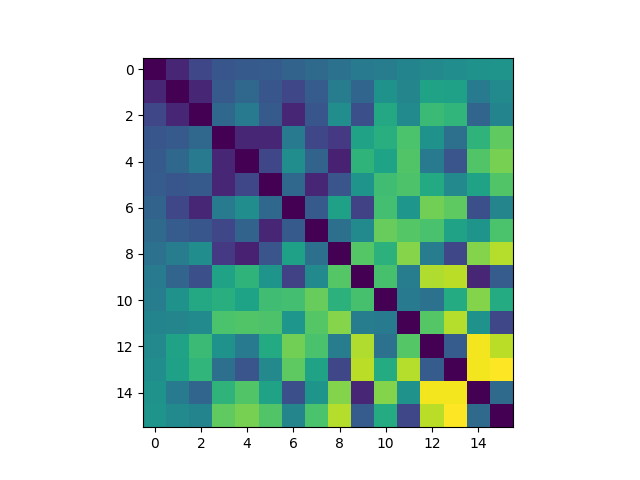

In [374]:
hs.signals.Signal1D(np.zeros())

In [377]:
all_adj_matrix = np.zeros(len(crystal.orientation_rotation_matrices),dtype=object)

In [382]:
all_adj_matrix[0] = adj_matrix


In [384]:
all_adj_matrix[1]

array([[0., 0.],
       [0., 0.]])